# Setting

In [4]:
outdir = './output'

import os
if not os.path.isdir(outdir):
    os.mkdir(outdir)
    pass

In [47]:
datadir = '/data/ms2840a'
filename = '2022-12-26_signaltest/DOSUE-K'
freqs = range(18, 27, 1)
filenames = [ f'{filename}_{i}GHz.dat' for i in freqs ]
labels = [ f'{i} GHz' for i in freqs ]
freq_min = 17.5 # [GHz]
freq_max = 26.5 # [GHz]
legendON = False
csvType = 'TwoColumn'; # freq, dBm


'''
datadir = '/data/ms2840a'
#filename = '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_2'
#filename = '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtLargeBB'
#filename = '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_many_wtMetal'
#nfile = 100
filename = '2022-08-26/data/DOSUE-Y_test_AllAmp_SWEEP_4_wtLargeBB'
nfile = 1
filenames = [ f'{filename}_{i}.dat' for i in range(nfile) ] if nfile > 1 else [ f'{filename}.dat' ]
labels = [ f'{i}' for i in range(nfile) ]  if nfile > 1 else [ filename.split('/')[-1] ]
freq_min = 3 # [GHz]
freq_max = 13 # [GHz]
legendON = False
csvType = 'TwoColumn'; # freq, dBm
'''

'''
datadir = '/Users/shadachi/Experiment/DOSUE/data/ms2840a/2022-02-01/data'
filenames = [
'Yfactor300K_sweep_KyotoMS2840A_1.dat',
'Yfactor300K_sweep_TohokuMS2840A_1.dat'
]
labels = [
    'Kyoto SpeAna', 
    'Tohoku SpeAna'
]
freq_min = 15. # [GHz]
freq_max = 28 # [GHz]
csvType = 'TwoColumn'; # freq, dBm
'''

# csv type examples:
# csvType = 'TwoColumn'; # freq, dBm
# csvType = 'Anritsu'; # Anritsu Spectrum analyzer: Waveform output
# csvType = 'Keysight'; # Keysight Spectrum Analyzer USB: output
# csvType = 'OneColumn'; # dBm 
# csvType = 'TwoColumn'; # freq, dBm

# default average binning
nFreqAve = 10 

# constant
k_B = 1.380649e-23  # boltzmann const. [J/K]

In [48]:
print(filenames)
print(labels)

['2022-12-26_signaltest/DOSUE-K_18GHz.dat', '2022-12-26_signaltest/DOSUE-K_19GHz.dat', '2022-12-26_signaltest/DOSUE-K_20GHz.dat', '2022-12-26_signaltest/DOSUE-K_21GHz.dat', '2022-12-26_signaltest/DOSUE-K_22GHz.dat', '2022-12-26_signaltest/DOSUE-K_23GHz.dat', '2022-12-26_signaltest/DOSUE-K_24GHz.dat', '2022-12-26_signaltest/DOSUE-K_25GHz.dat', '2022-12-26_signaltest/DOSUE-K_26GHz.dat']
['18 GHz', '19 GHz', '20 GHz', '21 GHz', '22 GHz', '23 GHz', '24 GHz', '25 GHz', '26 GHz']


# Import libraries

In [19]:
import csv
import numpy as np
import matplotlib.pyplot as plt
# set colorful lines
cmap = plt.get_cmap('jet')

# Define function to read csv datafile

In [20]:
# start_freq, stop_freq, npoints are only used in OneColumn type
def read_csv(filename, csvType='Anritsu', start_freq=None, stop_freq=None, npoints=None):
    
    freq = [] # frequency list [GHz]
    power = [] # power list  [mW]
    
    f = open(filename, 'r');
    if csvType=='TwoColumn':
        fin = list( csv.reader(f, delimiter=' ') )
    else:
        fin = list(csv.reader(f))
    #print(fin)  #リストの中身を出力
    isData = False
    
    if csvType=='Anritsu': # Anritsu : NOTE: only for RMS detection
        
        start_freq = 0
        stop_freq = 0
        npoints = 0
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            # Search for frequency range
            if first == 'Trace-A':
                start_freq = int(line[1])
                stop_freq  = int(line[2])
                continue
            # Search for npoints
            if first == 'RMS':
                npoints = int(line[1])
                continue
            # Search for data starting point (Anritsu: Wave Data)
            if first.startswith('Wave Data'):
                isData = True
                continue
            # Get data
            if isData:
                power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
                pass
            pass
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
            
    elif csvType=='Keysight' : # Keysight
        
        for line in fin:
            if len(line)==0 : continue
            # Search for data starting point (Keysight: DATA)
            #print(f'first = {first}')
            if first == 'DATA':
                isData = True
                continue
            isData = True # All lines are data
            # Get data
            if isData:
                freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
                power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
                pass
            pass
        
    elif csvType=='TwoColumn' : # Hz, dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            freq.append( float(line[0]) * 1.e-9 ) # Hz --> GHz
            power.append(10 ** (float(line[1])*0.1)) # dBm --> mW
            pass
        
    elif csvType=='OneColumn' : # dBm
        
        for line in fin:
            if len(line)==0 : continue
            first = line[0].strip()
            #print(f'first = {first}')
            if first[0]=='#':
                # skip line
                continue
            # Get data
            power.append(10 ** (float(line[0])*0.1)) # dBm --> mW
            pass
        if (start_freq is None) or (stop_freq is None) or (npoints is None):
            print('Error! There is no arguments for frequency information (start_freq, stop_freq, npoints).')
            print('Error! Please specify them!')
            return None
        freq = np.linspace(start_freq,stop_freq,npoints) * 1.e-9 # Hz --> GHz
        
        pass
    
    return np.array(freq), np.array(power)
                

# Define funcition to calculate frequency average

In [21]:
def freq_average(data, naverage=100):

    ndata = len(data)
    npoints = int(ndata/naverage)
    
    data_ave = []
    data_err = []
    
    for i in range(npoints):
        data_subset = data[i*naverage:(i+1)*naverage]
        average = np.mean(data_subset)
        average_err = np.std(data_subset)/np.sqrt(naverage) #  = 1/N * sqrt( sum((y-mean)^2))  ( std = sqrt( sum((y-mean)^2) / N) )
        data_ave.append(average)
        data_err.append(average_err)
        pass
    
    return np.array(data_ave), np.array(data_err)

# Define function to interpolate spectrum over frequency

In [22]:
# interp_kind = 'linear': linear interpolation
# interp_kind = 'cubic' : splineinterpolation
from scipy import interpolate
def freq_interpolate(freq, freq1, power1, interp_kind='cubic'):
    interp_func = interpolate.interp1d(freq1, power1, kind=interp_kind)
    return interp_func(freq)

# Read csv data

In [23]:
freqs_array = []
powers_array = []
for filename in filenames:
    _freq, _power = read_csv(f'{datadir}/{filename}', csvType)
    
    # Select data between freq_min and freq_max
    _power = _power[_freq<=freq_max]
    _freq = _freq[_freq<=freq_max]
    _power = _power[_freq>=freq_min]
    _freq = _freq[_freq>=freq_min]
    
    freqs_array.append(_freq)
    powers_array.append(_power)
    pass

freqs_array = np.array(freqs_array)
powers_array = np.array(powers_array)

In [24]:
print(freqs_array)
print(powers_array)
print(freqs_array)
print(powers_array)

[[17.984375   17.9843751  17.98437519 ... 18.01562481 18.0156249
  18.015625  ]
 [18.984375   18.9843751  18.98437519 ... 19.01562481 19.0156249
  19.015625  ]
 [19.984375   19.9843751  19.98437519 ... 20.01562481 20.0156249
  20.015625  ]
 ...
 [23.984375   23.9843751  23.98437519 ... 24.01562481 24.0156249
  24.015625  ]
 [24.984375   24.9843751  24.98437519 ... 25.01562481 25.0156249
  25.015625  ]
 [25.984375   25.9843751  25.98437519 ... 26.01562481 26.0156249
  26.015625  ]]
[[2.73382449e-09 1.92157045e-09 1.13256772e-09 ... 7.59705008e-09
  4.83096583e-09 2.21279770e-09]
 [1.80989679e-10 3.37997211e-10 2.03411165e-10 ... 1.18156988e-09
  1.68602442e-09 1.37708347e-09]
 [6.48814906e-10 6.61090049e-10 5.30730584e-10 ... 6.28128358e-10
  3.01801805e-10 5.11097461e-10]
 ...
 [1.79013672e-09 2.01605020e-09 2.49358331e-09 ... 2.13212750e-09
  2.69768579e-09 2.35155661e-09]
 [1.67652288e-09 6.01405195e-10 1.33619237e-10 ... 1.37897898e-09
  1.52059551e-09 1.49907185e-09]
 [3.87773417e-

###  Plot Power [mW]

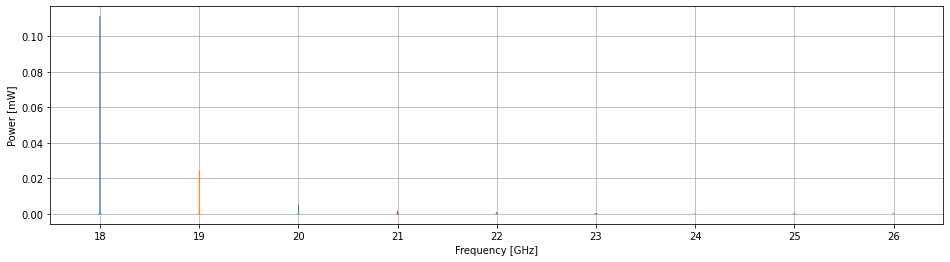

In [25]:
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    plt.plot(freqs_array[i], powers_array[i], label=f'{i}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    pass
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定
plt.grid(True)

if legendON: plt.legend()

#plt.savefig(f'{outdir}/compare_multiple_power_mW.png')
plt.show()

ValueError: A value in x_new is below the interpolation range.

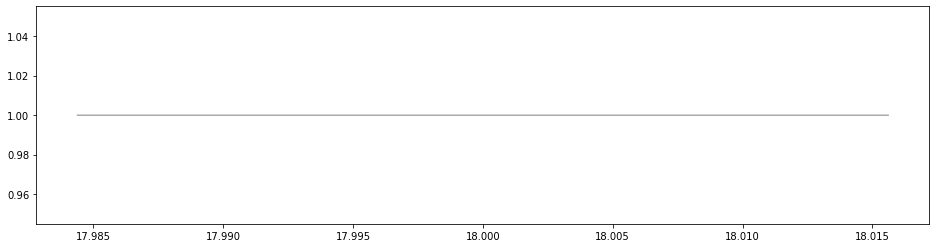

In [26]:
freq0 = freqs_array[0]
power0 = powers_array[0]
fig = plt.figure(figsize=(16,4))
plt.plot(freq0, np.full(len(freq0), 1.), color='k', linewidth=0.5, linestyle='-')
for i, filename in enumerate(filenames):
    if i==0: continue
    power_interp = freq_interpolate(freq0, freqs_array[i], powers_array[i])
    div_power =power_interp/power0
    plt.plot(freq0, div_power, label=f'{i}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'Divided by \n i=0:{filenames[0]}') #y軸の名前
#plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_div.png')
plt.show()

##  Plot Power [dBm]

###  Plot Power [dBm] in the same figure

power > -65 dB: 0 @ [17.99999981] GHz
power > -65 dB: 1 @ [18.99999981] GHz
power > -65 dB: 2 @ [19.99999981] GHz
power > -65 dB: 3 @ [20.99999981] GHz
power > -65 dB: 4 @ [21.99999981] GHz
power > -65 dB: 5 @ [22.99999971] GHz
power > -65 dB: 6 @ [23.99999971] GHz
power > -65 dB: 7 @ [24.99999971] GHz
power > -65 dB: 8 @ [25.99999971] GHz


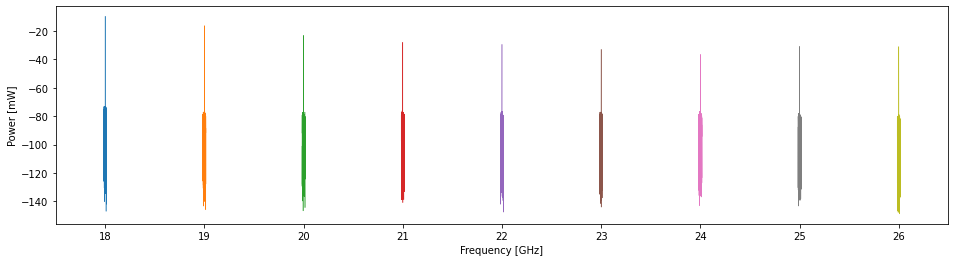

In [27]:
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    power_dBm = np.log10(powers_array[i])*10.
    plt.plot(freqs_array[i], power_dBm, label=f'{i}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    #cutdBm = -60
    cutdBm = -65
    if max(power_dBm)>cutdBm: 
        print(f'power > {cutdBm} dB: {i} @ {freqs_array[i][power_dBm==np.max(power_dBm)]} GHz')
        pass
    pass
plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定

if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power_dBm.png')
plt.show()

###  Plot Power [dBm] in each panel

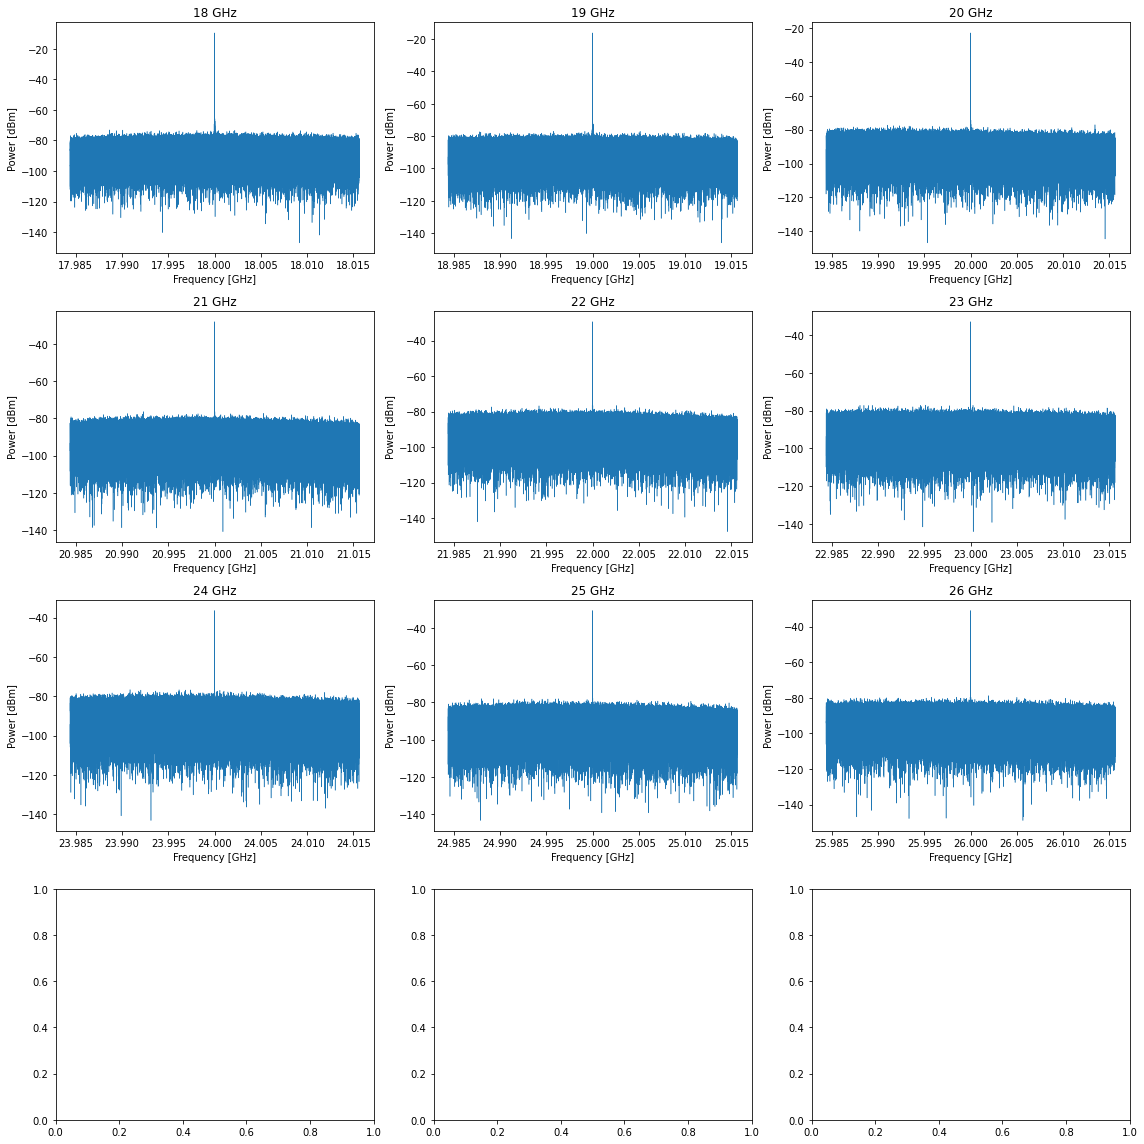

In [53]:
fig, axes = plt.subplots((int)(len(filenames)/3)+1, 3, figsize=(16,16), sharex=False, squeeze=False)
for n, filename in enumerate(filenames):
    i = (int)(n/3)
    j = n%3
    ax = axes[i][j]
    ax.set_title(labels[n])
    power_dBm = np.log10(powers_array[n])*10.
    ax.plot(freqs_array[n], power_dBm, label=f'{labels[n]}', marker='', markersize=0.5, linestyle='-', linewidth=0.5)
    ax.set_xlabel('Frequency [GHz]') #x軸の名前
    ax.set_ylabel('Power [dBm]') #y軸の名前
    pass

if legendON: plt.legend()

plt.tight_layout()
plt.savefig(f'{outdir}/compare_multiple_power_dBm_eachpanel.pdf')
plt.show()

### Plot max frequency

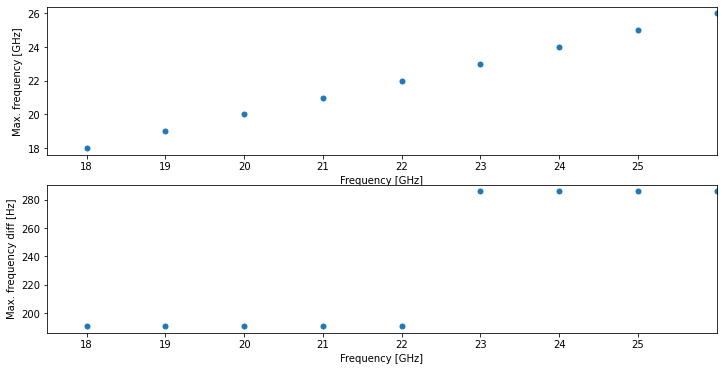

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=False)
freq_maxs = []
freq_maxs_round = []
freq_maxs_diff = []
for i, filename in enumerate(filenames):
    max_power = max(powers_array[i])
    freq_max = freqs_array[i][powers_array[i]==max_power][0]
    freq_maxs.append(freq_max)
    freq_maxs_round.append(np.round(freq_max))
    freq_maxs_diff.append((np.round(freq_max)-freq_max)*1e+9)
    #print(f'label = {labels[i]}')
    #print(f'max power = {np.log10(max_power)*10} dBm')
    #print(f'max freq = {freq_max} GHz')
    pass
ax = axes[0]
ax.plot(freq_maxs_round, freq_maxs, ls='', markersize=5, marker='o')
ax.set_xlabel('Frequency [GHz]') #x軸の名前
ax.set_ylabel('Max. frequency [GHz]') #y軸の名前
ax.set_xlim(freq_min,freq_max) #x軸範囲指定
#plt.xlim(5,20) #x軸範囲指定
#plt.ylim(0,0.02) #y軸範囲指定
#plt.ylim(0,0.003) #y軸範囲指定
if legendON: ax.legend()
    
ax = axes[1]
ax.plot(freq_maxs_round, freq_maxs_diff, ls='', markersize=5, marker='o')
ax.set_xlabel('Frequency [GHz]') #x軸の名前
ax.set_ylabel('Max. frequency diff [Hz]') #y軸の名前
ax.set_xlim(freq_min,freq_max) #x軸範囲指定
if legendON: ax.legend()

#plt.savefig(f'{outdir}/compare_multiple_power_dBm.png')
plt.show()

### Plot averaged power

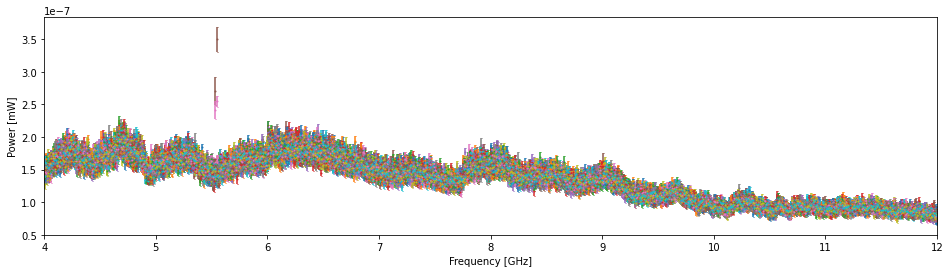

In [13]:
## Averaging
freqs_ave_array = []
powers_ave_array = []
powers_ave_err_array = []
for i, filename in enumerate(filenames):
    _freq_ave, tmp = freq_average(freqs_array[i], naverage=nFreqAve)
    _power_ave, _power_ave_err = freq_average(powers_array[i], naverage=nFreqAve)
    freqs_ave_array.append(_freq_ave)
    powers_ave_array.append(_power_ave)
    powers_ave_err_array.append(_power_ave_err)
    pass
freqs_ave_array = np.array( freqs_ave_array )
powers_ave_array = np.array( powers_ave_array )
powers_ave_err_array = np.array( powers_ave_err_array )

## Plotting
fig = plt.figure(figsize=(16,4))
for i, filename in enumerate(filenames):
    plt.errorbar(freqs_ave_array[i], powers_ave_array[i], yerr=powers_ave_err_array[i], 
                 label=f'{i}', capsize=0.5, fmt='o', markersize=1, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel('Power [mW]') #y軸の名前
plt.xlim(freq_min,freq_max) #x軸範囲指定
#plt.ylim(0,0.006) #y軸範囲指定
if legendON: plt.legend()

plt.savefig(f"{outdir}/compare_multiple_power_average.png")
plt.show()

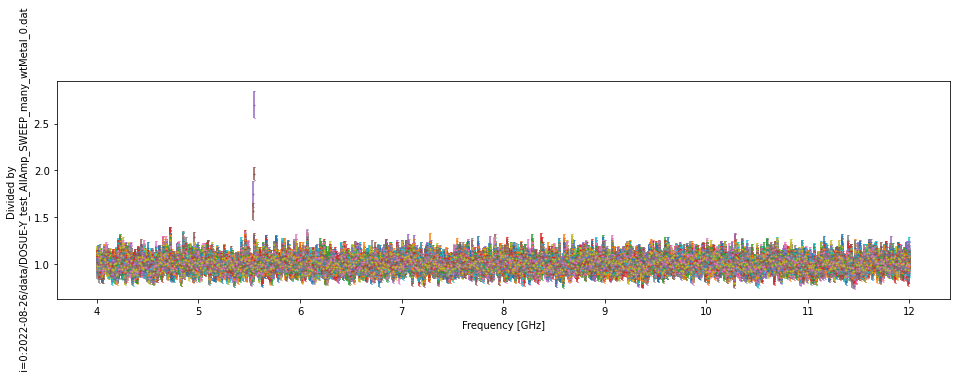

In [14]:
freq0 = freqs_ave_array[0]
power0 = powers_ave_array[0]
fig = plt.figure(figsize=(16,4))
plt.plot(freq0, np.full(len(freq0), 1.), color='k', linewidth=0.5, linestyle='-')
for i, filename in enumerate(filenames):
    if i==0: continue
    power_interp = freq_interpolate(freq0, freqs_ave_array[i], powers_ave_array[i])
    power_err_interp = freq_interpolate(freq0, freqs_ave_array[i], powers_ave_err_array[i])
    div_power = power_interp/power0
    div_power_err = power_err_interp/power0
    plt.errorbar(freq0, div_power, yerr=div_power_err, 
                 label=f'{i}', capsize=0.5, fmt='o', markersize=1, 
                 #ecolor=colors[i], markeredgecolor = colors[i], color=colors[i],
                )
    pass

plt.xlabel('Frequency [GHz]') #x軸の名前
plt.ylabel(f'Divided by \n i=0:{filenames[0]}') #y軸の名前
if legendON: plt.legend()

plt.savefig(f'{outdir}/compare_multiple_power-ave_div.png')
plt.show()